In [1]:
# Load pickled data
import pickle
#importing some useful packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import flatten
%matplotlib inline

In [2]:
# TODO: fill this in based on where you saved the training and testing data
training_file = 'datasets//train.p'
testing_file = 'datasets//test.p'
aug_training_file = 'datasets//aug_train.p'

# with open(training_file, mode='rb') as f:
#     train = pickle.load(f)
with open(aug_training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

valid=dict()

In [3]:
### Replace each question mark with the appropriate value.

# TODO: number of training examples
n_train = len(train['features'])

# TODO: number of testing examples
n_test = len(test['features'])

# TODO: what's the shape of an image?
image_shape = train['features'][0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))
labels_shape = train['labels'].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Labels data shape =", labels_shape)
print("Number of classes =", n_classes)

Number of training examples = 41469
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Labels data shape = (41469,)
Number of classes = 43


In [4]:
def normalize(image):
    _min=image.min()
    _max=image.max()
    img = ((image-_min) /(_max-_min))
    return img

train['features'] = np.array([normalize(im) for im in train['features']])
test['features'] = np.array([normalize(im) for im in test['features']])

## save data for data augmentation

In [15]:
aug_training_file = 'datasets//aug_train.p'
    
with open(aug_training_file, 'wb') as handle:
    pickle.dump(train, handle, protocol=pickle.HIGHEST_PROTOCOL)

---

In [5]:
labels_one_hot=np.zeros([train['labels'].shape[0],n_classes])
for i,l in enumerate(train['labels']):
    labels_one_hot[i][l]=1
train['labels']=labels_one_hot

labels_one_hot=np.zeros([test['labels'].shape[0],n_classes])
for i,l in enumerate(test['labels']):
    labels_one_hot[i][l]=1
test['labels']=labels_one_hot

In [6]:
from sklearn.model_selection import train_test_split
train['features'], valid['features'], train['labels'], valid['labels'] = train_test_split( train['features'], 
   train['labels'],
   test_size=0.2,
   random_state=122333)

In [7]:
layer_width = {
    'conv1': 32,
    'conv2': 128,
    'fc1': 1024,
    'fc2': 1024,
    'fc3': n_classes
}
filter_size=[3,3]

tf.reset_default_graph() 
with tf.variable_scope('karol', reuse=False):
    weights = {
        'conv1': tf.get_variable("conv1w", shape=[filter_size[0], filter_size[1], image_shape[2], layer_width['conv1']], initializer=tf.contrib.layers.xavier_initializer()),
        'conv2': tf.get_variable("conv2w", shape=[filter_size[0], filter_size[1], layer_width['conv1'], layer_width['conv2']], initializer=tf.contrib.layers.xavier_initializer()),
        'fc1':  tf.get_variable("fc1w", shape=[image_shape[0]*image_shape[1]*layer_width['conv2'], layer_width['fc1']], initializer=tf.contrib.layers.xavier_initializer()),
        'fc2':  tf.get_variable("fc2w", shape=[layer_width['fc1'], layer_width['fc2']], initializer=tf.contrib.layers.xavier_initializer()),
        'fc3':  tf.get_variable("fc3w", shape=[layer_width['fc2'], layer_width['fc3']], initializer=tf.contrib.layers.xavier_initializer())
    }

    biases = {
        'conv1': tf.get_variable("conv1b", shape=[layer_width['conv1']], initializer=tf.contrib.layers.xavier_initializer()),
        'conv2': tf.get_variable("conv2b", shape=[layer_width['conv2']], initializer=tf.contrib.layers.xavier_initializer()),
        'fc1': tf.get_variable("fc1b", shape=[layer_width['fc1']], initializer=tf.contrib.layers.xavier_initializer()),
        'fc2': tf.get_variable("fc2b", shape=[layer_width['fc2']], initializer=tf.contrib.layers.xavier_initializer()),
        'fc3': tf.get_variable("fc3b", shape=[layer_width['fc3']], initializer=tf.contrib.layers.xavier_initializer())
    }
for key,val in sorted(layer_width.items()):
    print("Layer %4s width is %s"%(key,val))
          
for key,val in sorted(weights.items()):
    print("Weights for %4s: %s"%(key,val))

Layer conv1 width is 32
Layer conv2 width is 128
Layer  fc1 width is 1024
Layer  fc2 width is 1024
Layer  fc3 width is 43
Weights for conv1: <tf.Variable 'karol/conv1w:0' shape=(3, 3, 3, 32) dtype=float32_ref>
Weights for conv2: <tf.Variable 'karol/conv2w:0' shape=(3, 3, 32, 128) dtype=float32_ref>
Weights for  fc1: <tf.Variable 'karol/fc1w:0' shape=(131072, 1024) dtype=float32_ref>
Weights for  fc2: <tf.Variable 'karol/fc2w:0' shape=(1024, 1024) dtype=float32_ref>
Weights for  fc3: <tf.Variable 'karol/fc3w:0' shape=(1024, 43) dtype=float32_ref>


In [8]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def fclayer(x,w,b):
    return tf.matmul(tf.contrib.layers.flatten(x), w) + b

In [9]:
def myNet(x):
    # conv layer
    net = conv2d(x,weights['conv1'],biases['conv1'])
    net = conv2d(net,weights['conv2'],biases['conv2'])

    # fully connected layers
    net = fclayer(net,weights['fc1'],biases['fc1'])
    net = tf.nn.relu(net)
    net = fclayer(net,weights['fc2'],biases['fc2'])
    net = tf.nn.relu(net)
    net = fclayer(net,weights['fc3'],biases['fc3'])

    return net

In [10]:
EPOCHS = 10
BATCH_SIZE = 150
LEARNING_RATE = 0.0001

print("Number of epochs: ",EPOCHS)
print("Batch size: ",BATCH_SIZE)

Number of epochs:  10
Batch size:  150


In [11]:
x = tf.placeholder(tf.float32, shape=[None,image_shape[0],image_shape[1],image_shape[2]])
y = tf.placeholder(tf.float32)

net = myNet(x)

# Loss computation
prediction = tf.nn.softmax(net)
cross_entropy = -tf.reduce_sum(y * tf.log(prediction + 1e-6), reduction_indices=1)
loss = tf.reduce_mean(cross_entropy)

# Accuracy computation
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

In [12]:

optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

batches = []
loss_epoch = []
train_acc_epoch = []
valid_acc_epoch = []
validation_accuracy = 0.0



init = tf.global_variables_initializer()

session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session.run(init)

# Merge all the summaries and write them out to /tmp/traffic-signs/train
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('/tmp/traffic-signs/train', session.graph)

batch_count = int(len(train['features']) / BATCH_SIZE)

for epoch in range(EPOCHS):
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch + 1, EPOCHS), unit='batches')

    for batch_i in batches_pbar:
        batch_start = batch_i * BATCH_SIZE
        batch_features = train['features'][batch_start:batch_start + BATCH_SIZE]
        batch_labels = train['labels'][batch_start:batch_start + BATCH_SIZE]

        _, l = session.run(
            [optimizer, loss],
            feed_dict={x: batch_features, y: batch_labels})
        
    training_accuracy = session.run(
        accuracy,
        feed_dict={x: batch_features, y: batch_labels}
    )
    
    
    idx = np.random.randint(len(valid['features']), size=int(BATCH_SIZE * .2))
    
    validation_accuracy = session.run(
        accuracy,
        feed_dict={x: valid['features'][idx,:], y: valid['labels'][idx,:]}
    )
    
    print('Epoch {:>2}/{}'.format(epoch + 1, EPOCHS))
    print (l)
    print (training_accuracy)
    print (validation_accuracy)
    
    
    batches.append(len(batches))
    loss_epoch.append(l)
    train_acc_epoch.append(training_accuracy)
    valid_acc_epoch.append(validation_accuracy)

Epoch  1/10: 100%|██████████████████████| 221/221 [10:36<00:00,  2.89s/batches]


Epoch  1/10
0.733737
0.846667
0.766667


Epoch  2/10: 100%|██████████████████████| 221/221 [10:43<00:00,  2.89s/batches]


Epoch  2/10
0.258264
0.966667
0.933333


Epoch  3/10: 100%|██████████████████████| 221/221 [11:10<00:00,  3.14s/batches]


Epoch  3/10
0.125499
0.986667
1.0


Epoch  4/10: 100%|██████████████████████| 221/221 [11:52<00:00,  3.42s/batches]


Epoch  4/10
0.0716011
1.0
0.966667


Epoch  5/10: 100%|██████████████████████| 221/221 [11:16<00:00,  2.92s/batches]


Epoch  5/10
0.0490248
1.0
1.0


Epoch  6/10: 100%|██████████████████████| 221/221 [10:58<00:00,  3.07s/batches]


Epoch  6/10
0.0282913
1.0
0.933333


Epoch  7/10: 100%|██████████████████████| 221/221 [11:04<00:00,  2.93s/batches]


Epoch  7/10
0.0347505
1.0
1.0


Epoch  8/10: 100%|██████████████████████| 221/221 [10:59<00:00,  2.91s/batches]


Epoch  8/10
0.0178008
1.0
1.0


Epoch  9/10: 100%|██████████████████████| 221/221 [10:51<00:00,  2.91s/batches]


Epoch  9/10
0.0130718
1.0
0.933333


Epoch 10/10: 100%|█████████████████████| 221/221 [45:42<00:00, 307.15s/batches]


Epoch 10/10
0.00563024
1.0
1.0


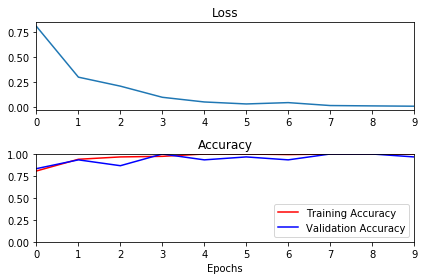

In [28]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_epoch)
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_epoch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_epoch, 'b', label='Validation Accuracy')
acc_plot.set_xlabel('Epochs')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()